# 本文件说明
- 统计分析

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import time

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_cor\%s_%s.jpg"%(now, title))

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_tend\%s_%s.jpg"%(now, title))
    
    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8   
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_uncor', 'sum']
    count_data_4['al_cor'] = count_data_4['sum'] - count_data_4['al_uncor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

In [9]:
# add_count = cbirc_add[cbirc_add['type'] == '建行北分']
# cbirc_day_thing
# title = "（建行北分）人工补录"
def plot_add(add_count, cbirc_day_thing, title):
    add_count = add_count.groupby('publishtime')['count'].sum()
    add_count = add_count.reset_index(['publishtime'])
    add_count = add_count.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    add_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
    ax1.set_ylabel('数据量', fontsize = 16)
    ax1.set_title(title, fontsize = 20)

    ax2 = ax1.twinx()  # this is the important function
    ax2.set_ylim(0, 1)
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in cbirc_day_thing:    
        if d in add_count['publishtime'].tolist():
            x = add_count['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(add_count.sort_values(by = 'publishtime', ascending = False).head())

# 参数设置

In [10]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2019-01-07
昨天是： 2019-01-06
统计的是昨天的数据，即 2019-01-06 的数据
start_day： 2018-12-07
end_day： 2019-01-07


In [11]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,
           '消费服务':6,'其他相关报道':7,'噪音':8,'交通':9,'环保':10}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音',
 9: '交通',
 10: '环保'}

In [12]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

In [13]:
proj_dic={'银监会':1,'保监会':2,'中国人寿':3,'建行北分':4,'中国人保':5,'安徽银监局':6}
proj_name_dict = {v: k for k, v in proj_dic.items()}
proj_name_dict

{1: '银监会', 2: '保监会', 3: '中国人寿', 4: '建行北分', 5: '中国人保', 6: '安徽银监局'}

# 保险业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [14]:
engine = specific_func.get_engine('circ')

In [15]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [16]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2019-01-07,补录,1
1,2019-01-07,监管,720
2,2019-01-07,行业,528
3,2019-01-07,产品销售,123
4,2019-01-07,资本市场,1932


In [17]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2019-01-07,噪音,12959
1,2019-01-06,噪音,42934
2,2019-01-05,噪音,26160
3,2019-01-04,噪音,74127
4,2019-01-03,噪音,99499


### 补录数据

,publishtime,补录
0,2019-01-07,1
22,2019-01-04,2
30,2019-01-03,6
38,2019-01-02,3
46,2019-01-01,1


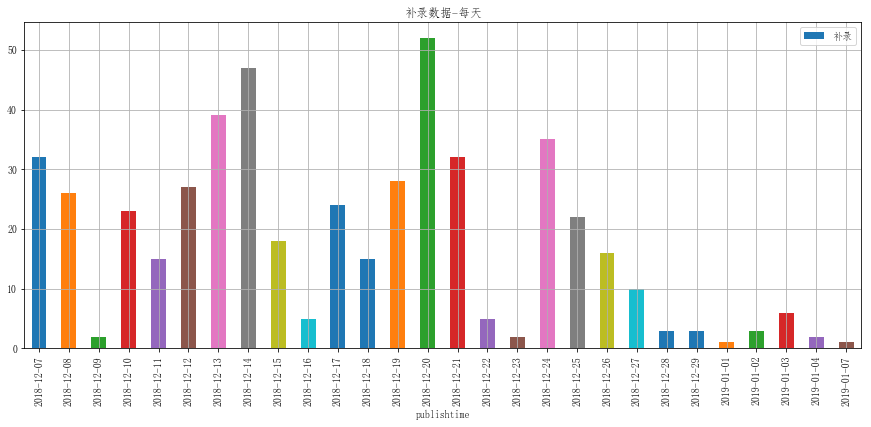

In [18]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [19]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2019-01-07   123.000  279.000   68.000 12959.000  223.000  720.000  528.000   
2019-01-06   377.000  785.000  415.000 42934.000 1437.000 1287.000  789.000   
2019-01-05   539.000 1008.000  268.000 26160.000 1791.000 3010.000 2940.000   
2019-01-04  1261.000 3632.000 1364.000 74127.000 2694.000 4987.000 3151.000   
2019-01-03  1752.000 3698.000 1354.000 99499.000 2055.000 3129.000 5569.000   

                                   总量       非噪音 非噪音-比例 噪音-比例  
classify       补录     资本市场                                    
publishtime                                                   
2019-01-07  1.000 1932.000  16833.000  3874.000  0.230 0.770  
2019-01-06    nan 2359.000  50383.000  7449.000  0.148 0.852  
2019-01-05    nan 2574.000  38290.000 12130.000  0.317 0.683  
2019-01-04  2.000 7826.000  99044.000 24917.000  0.252 0.748  
2019-01-03  6.000 8685.000 125747.000 26248.000  0.209 0.791

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2019-01-07   123.000  279.000   68.000 12959.000  223.000  720.000  528.000   
2019-01-06   377.000  785.000  415.000 42934.000 1437.000 1287.000  789.000   
2019-01-05   539.000 1008.000  268.000 26160.000 1791.000 3010.000 2940.000   
2019-01-04  1261.000 3632.000 1364.000 74127.000 2694.000 4987.000 3151.000   
2019-01-03  1752.000 3698.000 1354.000 99499.000 2055.000 3129.000 5569.000   

                                   总量  rate                                  \
classify       补录     资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                   
2019-01-07  1.000 1932.000  16833.000 0.007  0.017  0.004 0.770 0.013 0.043   
2019-01-06    nan 2359.000  50383.000 0.007  0.016  0.008 0.852 0.029 0.026   
2019-01-05    nan 2574.000  38290.000 0.014  0.026  0.007 0.683 0.047 0.079   
2019-01-04  2.000 7826.000  99044.000 0.013  0.037  0.014 0.748 0.027 0.050   
2019-01-03  6.000 8685.000 125747.000 0.014  0.029  0.011 0.791 0.016 0.025   

                               
classify       行业    补录  资本市场  
publishtime                    
2019-01-07  0.031 0.000 0.115  
2019-01-06  0.016   nan 0.047  
2019-01-05  0.077   nan 0.067  
2019-01-04  0.032 0.000 0.079  
2019-01-03  0.044 0.000 0.069

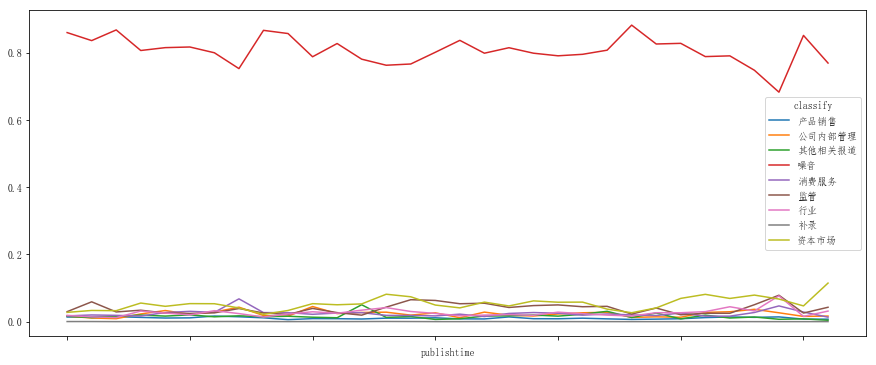

In [20]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

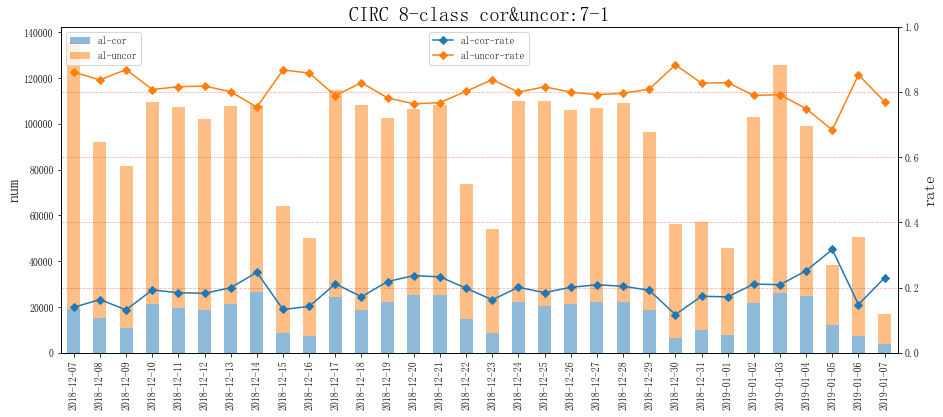

   publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2019-01-07  16833.000  3874.000 12959.000        0.230          0.770
30  2019-01-06  50383.000  7449.000 42934.000        0.148          0.852
29  2019-01-05  38290.000 12130.000 26160.000        0.317          0.683
28  2019-01-04  99044.000 24917.000 74127.000        0.252          0.748
27  2019-01-03 125747.000 26248.000 99499.000        0.209          0.791


In [21]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

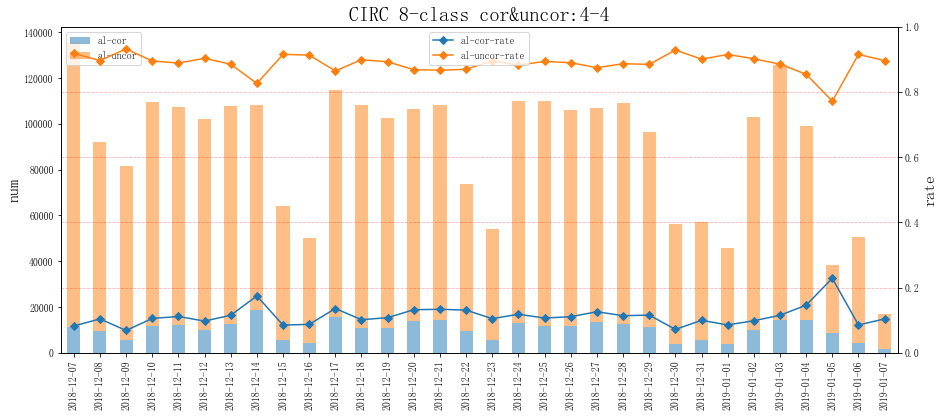

   publishtime   al_uncor        sum    al_cor  al_cor_rate  al_uncor_rate
31  2019-01-07  15082.000  16833.000  1751.000        0.104          0.896
30  2019-01-06  46085.000  50383.000  4298.000        0.085          0.915
29  2019-01-05  29541.000  38290.000  8749.000        0.228          0.772
28  2019-01-04  84578.000  99044.000 14466.000        0.146          0.854
27  2019-01-03 111290.000 125747.000 14457.000        0.115          0.885


In [22]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [23]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2019-01-07,-1,391
1,2019-01-07,0,3537
2,2019-01-06,-1,1508
3,2019-01-06,0,5941
4,2019-01-05,-1,2419


In [24]:
tend_count[~tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,count
30,2018-12-24,1,4
39,2018-12-20,1,11
42,2018-12-19,1,10
47,2018-12-17,1,6
54,2018-12-14,1,6


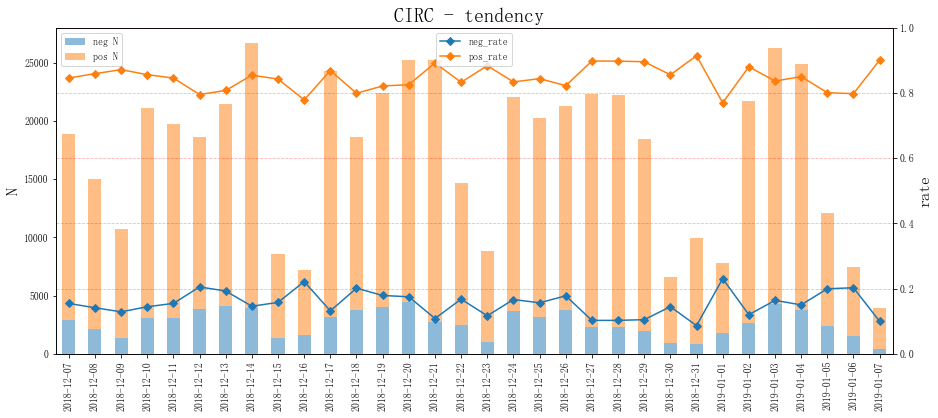

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2019-01-07   391   3537   3928     0.100     0.900
30  2019-01-06  1508   5941   7449     0.202     0.798
29  2019-01-05  2419   9712  12131     0.199     0.801
28  2019-01-04  3740  21177  24917     0.150     0.850
27  2019-01-03  4300  21948  26248     0.164     0.836


In [25]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [26]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [27]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-30
add_end_day： 2019-01-06


In [28]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(12, 7)


In [29]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(32, 7)


In [30]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (44, 7)
去重后 (32, 7)


In [31]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,13131534,行业,,1,1
1,13132549,行业,,1,1
2,13133731,行业,,1,1
3,13156632,行业,,1,1
4,13156725,行业,,1,1


In [32]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [33]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [34]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,纸媒,总量
保监会：2018-12-30 到 2019-01-06,,,,
补录,4.000,6.000,2.000,12.000
预警数量,4.000,15.000,13.000,32.000
补录且预警,4.000,6.000,2.000,12.000
补录&过算法(7类),4.000,6.000,2.000,12.000
补录且预警&过算法(7类),4.000,6.000,2.000,12.000
补录且预警 / 预警-比例,100%,40%,15%,38%
补录且预警 / 补录-比例,100%,100%,100%,100%
补录&过算法(7类) / 补录-比例,100%,100%,100%,100%
补录且预警&过算法(7类) / 补录且预警-比例,100%,100%,100%,100%


### 导出一段时间补录数据用于训练

In [35]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [36]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [37]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [38]:
engine = specific_func.get_engine('cbrc')

In [39]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [40]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2019-01-07,监管,989
1,2019-01-07,行业,4960
2,2019-01-07,产品销售,369
3,2019-01-07,资本市场,4785
4,2019-01-07,公司内部管理,485


### class

In [41]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                       总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务    监管     行业   资本市场           
publishtime                                                                  
2019-01-07    369    485    900   16525   1441   989   4960   4785   30454   
2019-01-06    990   1608   1968   52460   6928  1792  11879   9215   86840   
2019-01-05   1293   1720   1550   60656   8622  4656  14262  13805  106564   
2019-01-04   3153   5154   3210   89710  12292  7702  22081  23155  166457   
2019-01-03   3154   4657   4968  107396  14874  8658  19201  22909  185817   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2019-01-07   13929  0.457 0.543  
2019-01-06   34380  0.396 0.604  
2019-01-05   45908  0.431 0.569  
2019-01-04   76747  0.461 0.539  
2019-01-03   78421  0.422 0.578

count                                                       总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务    监管     行业   资本市场           
publishtime                                                                  
2019-01-07    369    485    900   16525   1441   989   4960   4785   30454   
2019-01-06    990   1608   1968   52460   6928  1792  11879   9215   86840   
2019-01-05   1293   1720   1550   60656   8622  4656  14262  13805  106564   
2019-01-04   3153   5154   3210   89710  12292  7702  22081  23155  166457   
2019-01-03   3154   4657   4968  107396  14874  8658  19201  22909  185817   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2019-01-07  0.012  0.016  0.030 0.543 0.047 0.032 0.163 0.157  
2019-01-06  0.011  0.019  0.023 0.604 0.080 0.021 0.137 0.106  
2019-01-05  0.012  0.016  0.015 0.569 0.081 0.044 0.134 0.130  
2019-01-04  0.019  0.031  0.019 0.539 0.074 0.046 0.133 0.139  
2019-01-03  0.017  0.025  0.027 0.578 0.080 0.047 0.103 0.123

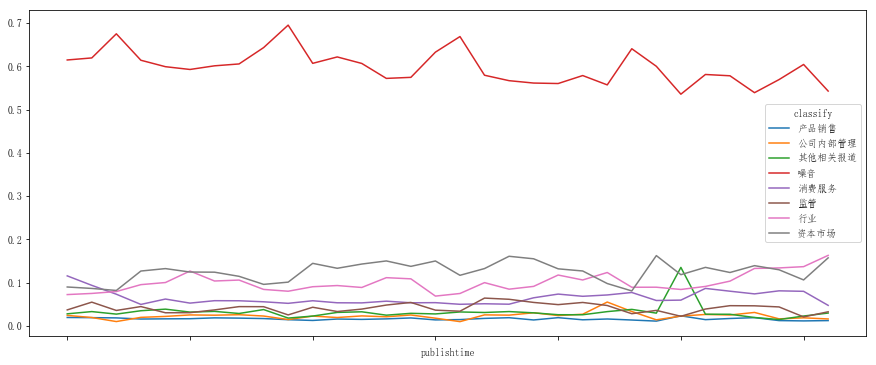

In [42]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

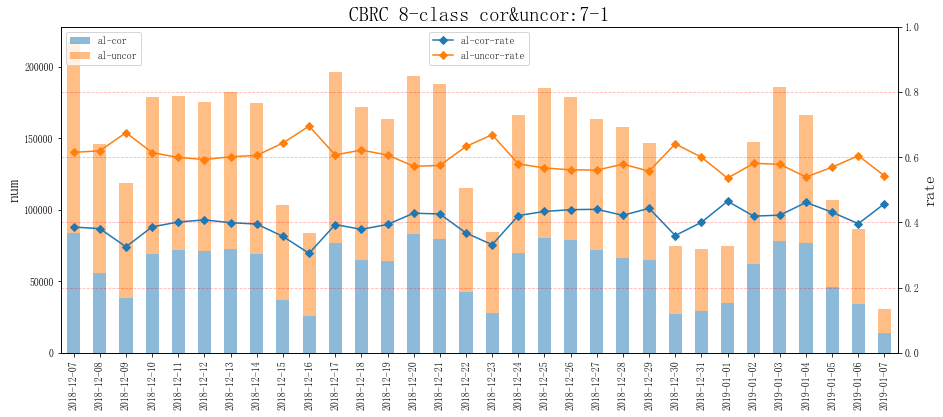

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2019-01-07   30454   13929     16525        0.457          0.543
30  2019-01-06   86840   34380     52460        0.396          0.604
29  2019-01-05  106564   45908     60656        0.431          0.569
28  2019-01-04  166457   76747     89710        0.461          0.539
27  2019-01-03  185817   78421    107396        0.422          0.578


In [43]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

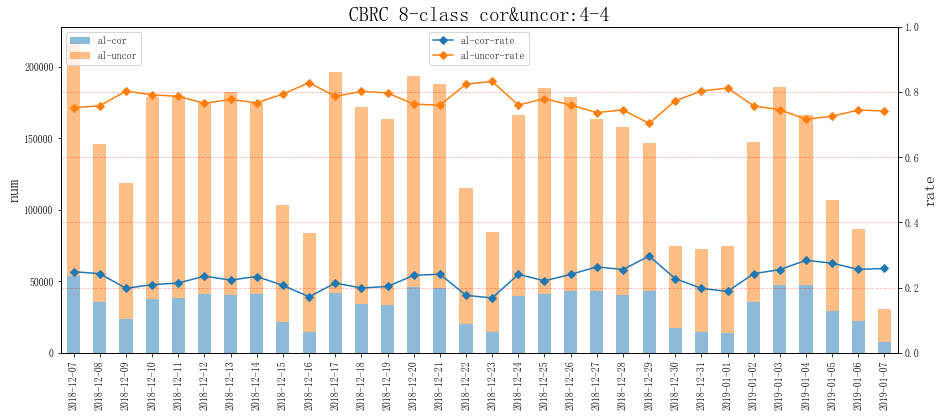

   publishtime  al_uncor     sum  al_cor  al_cor_rate  al_uncor_rate
31  2019-01-07     22579   30454    7875        0.259          0.741
30  2019-01-06     64633   86840   22207        0.256          0.744
29  2019-01-05     77304  106564   29260        0.275          0.725
28  2019-01-04    119228  166457   47229        0.284          0.716
27  2019-01-03    138427  185817   47390        0.255          0.745


In [44]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [45]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2019-01-07,-1,973
1,2019-01-07,0,7007
2,2019-01-06,-1,4179
3,2019-01-06,0,18033
4,2019-01-05,-1,6052


In [46]:
tend_count[tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,cor_count
0,2019-01-07,-1,973
1,2019-01-07,0,7007
2,2019-01-06,-1,4179
3,2019-01-06,0,18033
4,2019-01-05,-1,6052


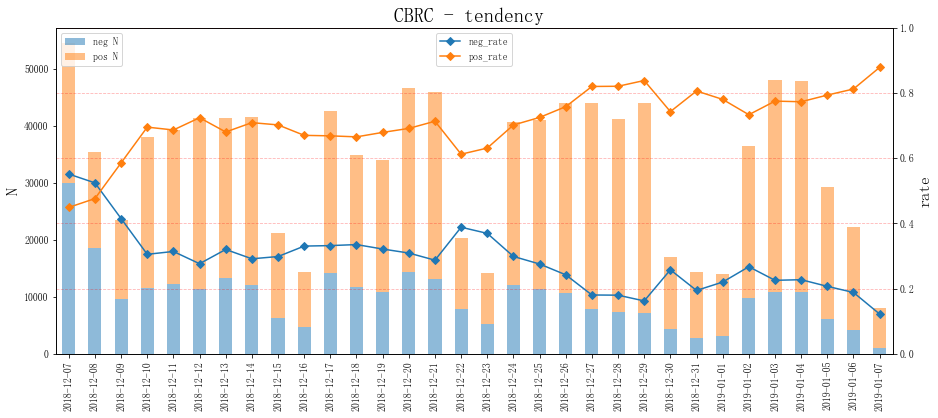

   publishtime    neg    pos    sum  neg_rate  pos_rate
31  2019-01-07    973   7007   7980     0.122     0.878
30  2019-01-06   4179  18033  22212     0.188     0.812
29  2019-01-05   6052  23213  29265     0.207     0.793
28  2019-01-04  10876  36996  47872     0.227     0.773
27  2019-01-03  10830  37239  48069     0.225     0.775


In [47]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [48]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2019-01-07,1,1
1,2019-01-06,1,4
2,2019-01-05,1,1
3,2019-01-04,1,29
4,2019-01-03,1,46


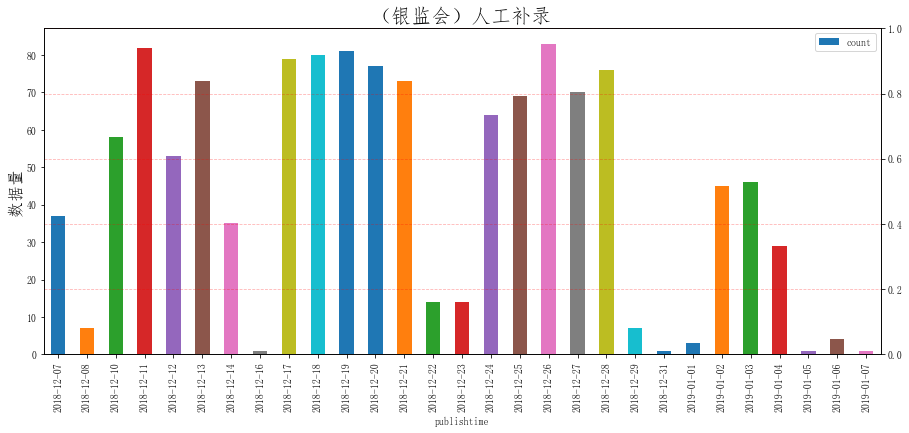

,publishtime,gather_type,count
0,2019-01-07,1,1
1,2019-01-06,1,4
2,2019-01-05,1,1
3,2019-01-04,1,29
4,2019-01-03,1,46


In [49]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [50]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-30
add_end_day： 2019-01-06


In [51]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(129, 7)


In [52]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(487, 7)


In [53]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (616, 7)
去重后 (487, 7)


In [54]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
4            微博        预警          119
人工修改         微博        预警          129
             新闻        预警           52
             纸媒        预警           43
             论坛        预警           15
人工补录         微信        预警            5
             微博        预警          109
             新闻        预警           13
             新闻客户端     预警            1
             纸媒        预警            1
Name: id, dtype: int64

In [55]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,273705804,公司内部管理,,0,1
1,273734129,行业,,1,1
2,273734131,噪音,,0,0
3,273736223,公司内部管理,,0,1
4,273744885,消费服务,,1,1


In [56]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [57]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [58]:
stat

,group_id,gather_type,submited,id
0,微信,人工补录,预警,5
1,微博,4,预警,119
2,微博,人工修改,预警,129
3,微博,人工补录,预警,109
4,新闻,人工修改,预警,52
5,新闻,人工补录,预警,13
6,新闻客户端,人工补录,预警,1
7,纸媒,人工修改,预警,43
8,纸媒,人工补录,预警,1
9,论坛,人工修改,预警,15


In [61]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微信,微博,新闻,纸媒,新闻客户端,总量
保监会：2018-12-30 到 2019-01-06,,,,,,
补录,5.000,109.000,13.000,1.000,0.000,128.000
预警数量,5.000,357.000,65.000,44.000,0.000,471.000
补录且预警,5.000,109.000,13.000,1.000,0.000,128.000
补录&过算法(4类),1.000,108.000,5.000,1.000,0.000,115.000
补录且预警&过算法(4类),1.000,108.000,5.000,1.000,0.000,115.000
补录&过算法(7类),3.000,108.000,11.000,1.000,1.000,124.000
补录且预警&过算法(7类),3.000,108.000,11.000,1.000,1.000,124.000
补录且预警 / 预警-比例,100%,31%,20%,2%,nan%,27%


### 导出一段时间补录数据用于训练

In [62]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [63]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [64]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 安徽银监局
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [65]:
engine = specific_func.get_engine('ahyjj')

In [66]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [67]:
start_day = today - datetime.timedelta(days=32) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)
len(day_list)

start_day： 2018-12-06
end_day： 2019-01-06
['2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06']


31

## 获取数据

In [68]:
for t in range(6, 7):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                db_classify_traffic_docinfo t1
                    LEFT JOIN
                db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, 1)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 安徽银监局 的数据 -------
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-07_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-08_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-09_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-10_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-11_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-12_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-13_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-14_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-15_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-16_mysql_stat.xlsx
   已存在： r

In [69]:
cbirc_count_all = pd.DataFrame()
for t in range(6, 7):
#     print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

In [70]:
# cbirc_count_all.rename(columns={'publistime': 'publishtime'}, inplace=True) 
print(cbirc_count_all.shape)
cbirc_count_all.head()

(1332, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,47,0,1,4,2018-12-07
1,1,1,0,30,0,1,4,2018-12-07
2,1,1,-1,7,0,11,4,2018-12-07
3,1,1,0,65,0,11,4,2018-12-07
4,1,1,-1,6,0,13,4,2018-12-07


### 八分类数据

In [71]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-12-07,1,1,166
1,2018-12-07,1,2,360
2,2018-12-07,1,3,49
3,2018-12-07,1,4,234
4,2018-12-07,1,5,293


In [72]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(244, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 4 columns):
publishtime    244 non-null object
type           244 non-null object
classify       244 non-null object
count          244 non-null int64
dtypes: int64(1), object(3)
memory usage: 64.1 KB
None
19743


sum       
             count       
type         安徽银监局    All
publishtime              
2018-12-07    2774   2774
2018-12-08    1225   1225
2018-12-09     896    896
2018-12-10    1154   1154
2018-12-11    1448   1448
2018-12-12     980    980
2018-12-13     682    682
2018-12-14     618    618
2018-12-15     254    254
2018-12-16     275    275
2018-12-17    1112   1112
2018-12-18     554    554
2018-12-19     456    456
2018-12-20     671    671
2018-12-21     525    525
2018-12-22     139    139
2018-12-23      60     60
2018-12-24     318    318
2018-12-25     733    733
2018-12-26     648    648
2018-12-27     553    553
2018-12-28     397    397
2018-12-29     539    539
2018-12-30     172    172
2018-12-31     130    130
2019-01-01     177    177
2019-01-02     645    645
2019-01-03     751    751
2019-01-04     456    456
2019-01-05     230    230
2019-01-06     171    171
All          19743  19743

### 倾向性数据

In [73]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-12-07,1,-1,415
1,2018-12-07,1,0,2359
2,2018-12-08,1,-1,242
3,2018-12-08,1,0,983
4,2018-12-09,1,-1,159


In [74]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(6)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-12-07,安徽银监局,-1,415
1,2018-12-07,安徽银监局,0,768
2,2018-12-08,安徽银监局,-1,242
3,2018-12-08,安徽银监局,0,169
4,2018-12-09,安徽银监局,-1,159


In [75]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(62, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
publishtime    62 non-null object
type           62 non-null object
tendency       62 non-null int64
count          62 non-null int64
dtypes: int64(2), object(2)
memory usage: 11.6 KB
None
19743


sum       
             count       
type         安徽银监局    All
publishtime              
2018-12-07    2774   2774
2018-12-08    1225   1225
2018-12-09     896    896
2018-12-10    1154   1154
2018-12-11    1448   1448
2018-12-12     980    980
2018-12-13     682    682
2018-12-14     618    618
2018-12-15     254    254
2018-12-16     275    275
2018-12-17    1112   1112
2018-12-18     554    554
2018-12-19     456    456
2018-12-20     671    671
2018-12-21     525    525
2018-12-22     139    139
2018-12-23      60     60
2018-12-24     318    318
2018-12-25     733    733
2018-12-26     648    648
2018-12-27     553    553
2018-12-28     397    397
2018-12-29     539    539
2018-12-30     172    172
2018-12-31     130    130
2019-01-01     177    177
2019-01-02     645    645
2019-01-03     751    751
2019-01-04     456    456
2019-01-05     230    230
2019-01-06     171    171
All          19743  19743

### 预警与补录数据

In [76]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count


In [77]:
# # cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
# cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(6)])
# print(cbirc_add.shape)
# print(cbirc_add.info(memory_usage = 'deep'))
# # cbirc_count.head()

# print(cbirc_add['count'].sum())
# cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
#                         aggfunc = [np.sum], values = ['count'], 
#                         fill_value = 0, margins = True)

## 八分类

In [78]:
class_count = cbirc_count[cbirc_count['type'] == '安徽银监局'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                      \
classify      产品销售  公司内部管理 其他相关报道     噪音   消费服务     监管      行业    资本市场   
publishtime                                                              
2019-01-06  30.000  18.000    nan 13.000 11.000 25.000  70.000   4.000   
2019-01-05   3.000  28.000  2.000 38.000 39.000  8.000 103.000   9.000   
2019-01-04   3.000  87.000 19.000 31.000 72.000 58.000 172.000  14.000   
2019-01-03  18.000 355.000  9.000 72.000 66.000 10.000 196.000  25.000   
2019-01-02   4.000 102.000 40.000 43.000 40.000  8.000 176.000 232.000   

                 总量     非噪音 非噪音-比例 噪音-比例  
classify                                  
publishtime                               
2019-01-06  171.000 158.000  0.924 0.076  
2019-01-05  230.000 192.000  0.835 0.165  
2019-01-04  456.000 425.000  0.932 0.068  
2019-01-03  751.000 679.000  0.904 0.096  
2019-01-02  645.000 602.000  0.933 0.067

count                                                      \
classify      产品销售  公司内部管理 其他相关报道     噪音   消费服务     监管      行业    资本市场   
publishtime                                                              
2019-01-06  30.000  18.000    nan 13.000 11.000 25.000  70.000   4.000   
2019-01-05   3.000  28.000  2.000 38.000 39.000  8.000 103.000   9.000   
2019-01-04   3.000  87.000 19.000 31.000 72.000 58.000 172.000  14.000   
2019-01-03  18.000 355.000  9.000 72.000 66.000 10.000 196.000  25.000   
2019-01-02   4.000 102.000 40.000 43.000 40.000  8.000 176.000 232.000   

                 总量  rate                                              
classify             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                            
2019-01-06  171.000 0.175  0.105    nan 0.076 0.064 0.146 0.409 0.023  
2019-01-05  230.000 0.013  0.122  0.009 0.165 0.170 0.035 0.448 0.039  
2019-01-04  456.000 0.007  0.191  0.042 0.068 0.158 0.127 0.377 0.031  
2019-01-03  751.000 0.024  0.473  0.012 0.096 0.088 0.013 0.261 0.033  
2019-01-02  645.000 0.006  0.158  0.062 0.067 0.062 0.012 0.273 0.360

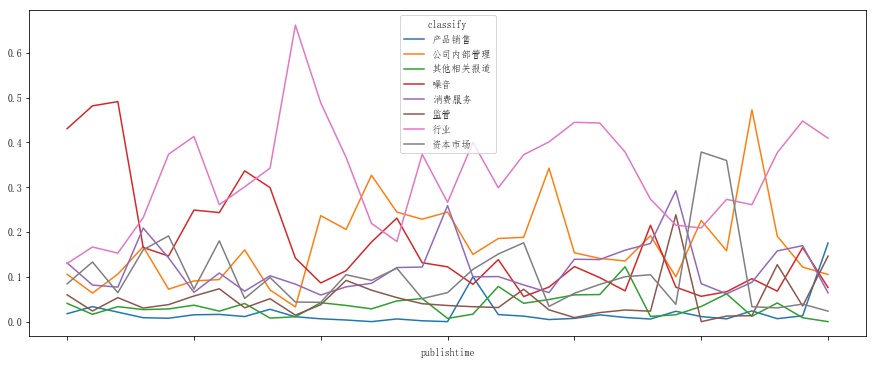

In [79]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

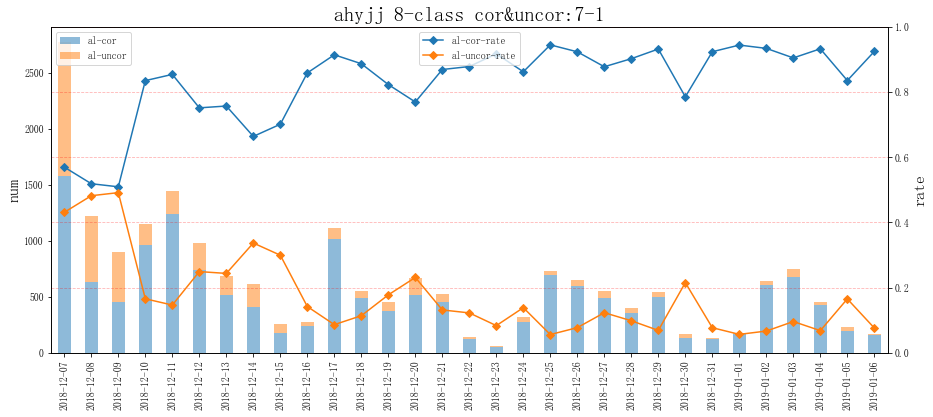

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
30  2019-01-06 171.000 158.000    13.000        0.924          0.076
29  2019-01-05 230.000 192.000    38.000        0.835          0.165
28  2019-01-04 456.000 425.000    31.000        0.932          0.068
27  2019-01-03 751.000 679.000    72.000        0.904          0.096
26  2019-01-02 645.000 602.000    43.000        0.933          0.067


In [80]:
plot_cor(count_data_7, cbirc_day_thing, "ahyjj 8-class cor&uncor:7-1")

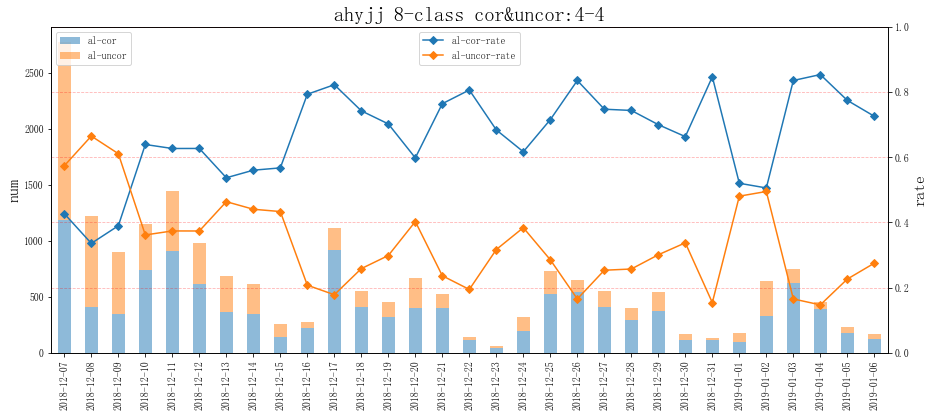

   publishtime  al_uncor     sum  al_cor  al_cor_rate  al_uncor_rate
30  2019-01-06    47.000 171.000 124.000        0.725          0.275
29  2019-01-05    52.000 230.000 178.000        0.774          0.226
28  2019-01-04    67.000 456.000 389.000        0.853          0.147
27  2019-01-03   124.000 751.000 627.000        0.835          0.165
26  2019-01-02   319.000 645.000 326.000        0.505          0.495


In [81]:
plot_cor(count_data_4, cbirc_day_thing, "ahyjj 8-class cor&uncor:4-4")

## 倾向性

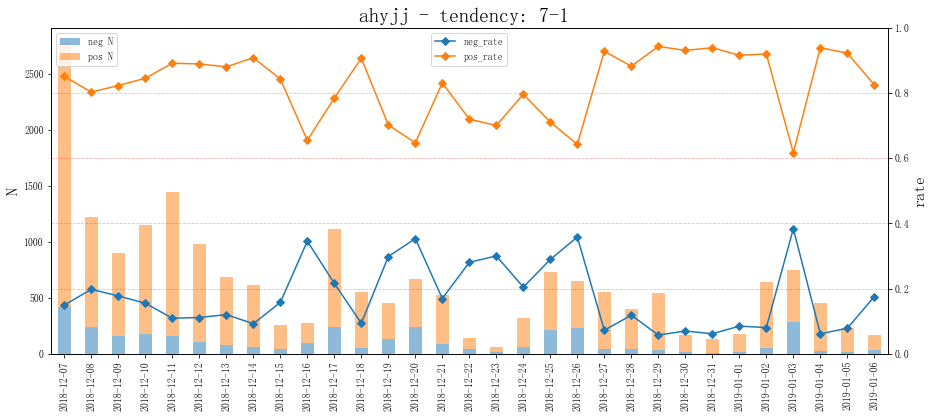

   publishtime  neg  pos  sum  neg_rate  pos_rate
30  2019-01-06   30  141  171     0.175     0.825
29  2019-01-05   18  212  230     0.078     0.922
28  2019-01-04   28  428  456     0.061     0.939
27  2019-01-03  288  463  751     0.383     0.617
26  2019-01-02   52  593  645     0.081     0.919


In [82]:
plot_tend(tend_count[tend_count['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency: 7-1 ")

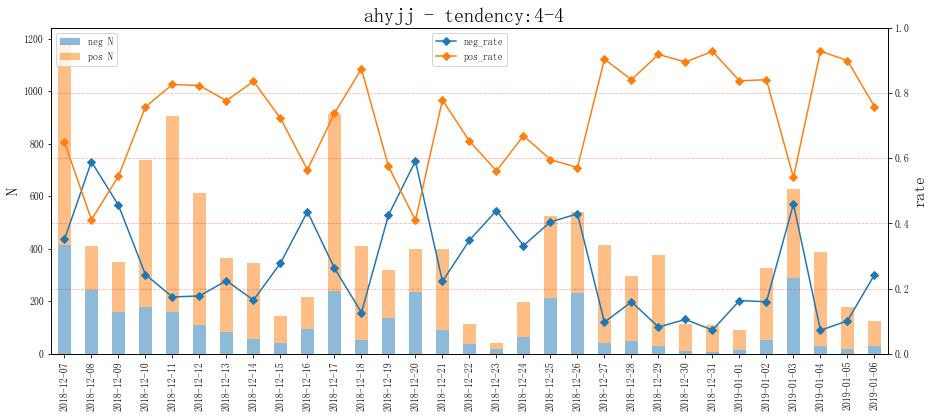

   publishtime  neg  pos  sum  neg_rate  pos_rate
30  2019-01-06   30   94  124     0.242     0.758
29  2019-01-05   18  160  178     0.101     0.899
28  2019-01-04   28  361  389     0.072     0.928
27  2019-01-03  288  339  627     0.459     0.541
26  2019-01-02   52  274  326     0.160     0.840


In [83]:
plot_tend(tend_count_4[tend_count_4['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency:4-4 ")

## 补录

In [84]:
# plot_add(cbirc_add[cbirc_add['type'] == '安徽银监局'], cbirc_day_thing, "（安徽银监局）人工补录")

# 银保监会--新

## 特殊时间点

In [85]:
engine = specific_func.get_engine('cbirc')

In [86]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [87]:
start_day = today - datetime.timedelta(days=30) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)

start_day： 2018-12-08
end_day： 2019-01-06
['2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06']


## 获取数据

In [88]:
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                cbrc_circ.db_classify_traffic_docinfo t1
                    LEFT JOIN
                cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, t)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 银监会 的数据 -------
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-09_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-10_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-11_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-12_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-13_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-14_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-15_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-16_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-17_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/银监会_2018-12-18_mysql_stat.xlsx
   已存在： result/statistics_resul

   日期：2019-01-03 ；耗时：32.6628680229187 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2019-01-03_mysql_stat.xlsx
   日期：2019-01-04 ；耗时：27.92359733581543 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2019-01-04_mysql_stat.xlsx
   日期：2019-01-05 ；耗时：19.98814344406128 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2019-01-05_mysql_stat.xlsx
   日期：2019-01-06 ；耗时：22.866307973861694 s
   已生成： result/statistics_result/mysql_daily_count_by_condition/中国人寿_2019-01-06_mysql_stat.xlsx
获取 建行北分 的数据 -------
   已存在： result/statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-09_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-10_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-11_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-12_mysql_stat.xlsx
   已存在： result/statistics_result/mysql_daily_cou

In [89]:
cbirc_count_all = pd.DataFrame()
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'result/statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

获取 银监会 的数据 -------
获取 保监会 的数据 -------
获取 中国人寿 的数据 -------
获取 建行北分 的数据 -------
获取 中国人保 的数据 -------


In [90]:
print(cbirc_count_all.shape)
cbirc_count_all.head()

(8962, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,133,0,1,4,2018-12-09
1,1,1,0,391,0,1,4,2018-12-09
2,1,1,-1,14,0,4,4,2018-12-09
3,1,1,0,8,0,4,4,2018-12-09
4,1,1,-1,1,0,5,4,2018-12-09


### 八分类数据

In [91]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-12-09,1,1,698
1,2018-12-09,1,2,1955
2,2018-12-09,1,3,1536
3,2018-12-09,1,4,3404
4,2018-12-09,1,5,1345


In [92]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(1212, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 4 columns):
publishtime    1212 non-null object
type           1212 non-null object
classify       1212 non-null object
count          1212 non-null int64
dtypes: int64(1), object(3)
memory usage: 314.0 KB
None
3309451


sum                                          
              count                                          
type           中国人保   中国人寿      保监会    建行北分      银监会      All
publishtime                                                  
2018-12-09    14927   1467    39247    1362    41982    98985
2018-12-10    23613   3067    52152    2523    67444   148799
2018-12-11    18922   3400    55011    1992    67409   146734
2018-12-12    13141   4664    57687    2032    73695   151219
2018-12-13    13861   5879    64195    2269    76649   162853
2018-12-14    15740   5233    63198    4782    70519   159472
2018-12-15    12144   1067    30775    2990    36086    83062
2018-12-16    15201    674    24445    1496    24706    66522
2018-12-17    15739   2677    57540    5673    57034   138663
2018-12-18    13408   3093    49150    3193    57036   125880
2018-12-19    11326   2845    40910    6911    43122   105114
2018-12-20    10481   4005    51211   13537    59536   138770
2018-12-21    10732   3052    50405   12106    57369   133664
2018-12-22     8647   1509    33938    4882    36865    85841
2018-12-23     8397    726    24840    3723    21017    58703
2018-12-24    12556   3661    54001    7967    57920   136105
2018-12-25     9817   2415    49821    7569    54508   124130
2018-12-26    12093   1914    45410    6308    57932   123657
2018-12-27     9291   2856    42602   10713    88111   153573
2018-12-28     4396   2117    30420    8530    94109   139572
2018-12-29     4793   1265    28070    7678    89412   131218
2018-12-30     4348    311    20200    2731    40587    68177
2018-12-31     4064   1003    17224    1142    38601    62034
2019-01-01     2702    351    10242     676    44902    58873
2019-01-02     7991   1822    32757    1664    73604   117838
2019-01-03    17739   4581    57086    1047    87561   168014
2019-01-04    10296   2922    38043     645    58439   110345
2019-01-05     5185   1217    23009     442    28510    58363
2019-01-06     6274   1410    17626     346    27615    53271
All          317824  71203  1161215  126929  1632280  3309451

### 倾向性数据

In [93]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-12-09,1,-1,1545
1,2018-12-09,1,0,40437
2,2018-12-09,2,-1,276
3,2018-12-09,2,0,38971
4,2018-12-09,3,-1,50


In [94]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(x)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-12-09,银监会,-1,1545
1,2018-12-09,银监会,0,3927
2,2018-12-09,保监会,-1,276
3,2018-12-09,保监会,0,2958
4,2018-12-09,中国人寿,-1,50


In [95]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(292, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 4 columns):
publishtime    292 non-null object
type           292 non-null object
tendency       292 non-null int64
count          292 non-null int64
dtypes: int64(2), object(2)
memory usage: 52.5 KB
None
3309451


sum                                          
              count                                          
type           中国人保   中国人寿      保监会    建行北分      银监会      All
publishtime                                                  
2018-12-09    14927   1467    39247    1362    41982    98985
2018-12-10    23613   3067    52152    2523    67444   148799
2018-12-11    18922   3400    55011    1992    67409   146734
2018-12-12    13141   4664    57687    2032    73695   151219
2018-12-13    13861   5879    64195    2269    76649   162853
2018-12-14    15740   5233    63198    4782    70519   159472
2018-12-15    12144   1067    30775    2990    36086    83062
2018-12-16    15201    674    24445    1496    24706    66522
2018-12-17    15739   2677    57540    5673    57034   138663
2018-12-18    13408   3093    49150    3193    57036   125880
2018-12-19    11326   2845    40910    6911    43122   105114
2018-12-20    10481   4005    51211   13537    59536   138770
2018-12-21    10732   3052    50405   12106    57369   133664
2018-12-22     8647   1509    33938    4882    36865    85841
2018-12-23     8397    726    24840    3723    21017    58703
2018-12-24    12556   3661    54001    7967    57920   136105
2018-12-25     9817   2415    49821    7569    54508   124130
2018-12-26    12093   1914    45410    6308    57932   123657
2018-12-27     9291   2856    42602   10713    88111   153573
2018-12-28     4396   2117    30420    8530    94109   139572
2018-12-29     4793   1265    28070    7678    89412   131218
2018-12-30     4348    311    20200    2731    40587    68177
2018-12-31     4064   1003    17224    1142    38601    62034
2019-01-01     2702    351    10242     676    44902    58873
2019-01-02     7991   1822    32757    1664    73604   117838
2019-01-03    17739   4581    57086    1047    87561   168014
2019-01-04    10296   2922    38043     645    58439   110345
2019-01-05     5185   1217    23009     442    28510    58363
2019-01-06     6274   1410    17626     346    27615    53271
All          317824  71203  1161215  126929  1632280  3309451

### 补录数据

In [96]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count
4,2018-12-09,4,1,1
6,2018-12-09,5,1,1
11,2018-12-10,3,1,3
14,2018-12-10,4,1,3
16,2018-12-10,5,1,6


In [97]:
# cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_add.shape)
print(cbirc_add.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_add['count'].sum())
cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(57, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 4 to 233
Data columns (total 4 columns):
publishtime    57 non-null object
type           57 non-null object
gather_type    57 non-null int64
count          57 non-null int64
dtypes: int64(2), object(2)
memory usage: 10.8 KB
None
231


sum                       
            count                       
type         中国人保 中国人寿 保监会 建行北分 银监会  All
gather_type     1    1   1    1   1     
publishtime                             
2018-12-09      1    0   0    1   0    2
2018-12-10      6    3   0    3   0   12
2018-12-11      2   10   0    2   0   14
2018-12-12      6    8   0    4   0   18
2018-12-13      3    8   0    5   0   16
2018-12-14      1    8   0    7   0   16
2018-12-15      0    0   0    2   0    2
2018-12-16      1    0   0    1   0    2
2018-12-17      4    0   0    1   0    5
2018-12-18      4    0   0    4   0    8
2018-12-19      2    0   0    2   0    4
2018-12-20      2    0   0    1   0    3
2018-12-21      2    0   0    1   0    3
2018-12-22      0    0   0    5   0    5
2018-12-23      1    0   0    1   0    2
2018-12-24      6    0   0    0   0    6
2018-12-25      6    0   0    0   0    6
2018-12-26      3    0   0    0   0    3
2018-12-27      4    0   0    8   0   12
2018-12-28      4    0   0   19   1   24
2018-12-29      5    0   0   16   0   21
2018-12-30      0    0   0    1   0    1
2018-12-31      1    0   0    1   0    2
2019-01-01      0    0   0    2   0    2
2019-01-02      8    1   1    3   2   15
2019-01-03      7    0   0    2   0    9
2019-01-04     12    0   0    2   0   14
2019-01-05      4    0   0    0   0    4
All            95   38   1   94   3  231

## 八分类
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [98]:
class_count = cbirc_count[cbirc_count['type'] == '银监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                   总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场                 
publishtime                                                                     
2019-01-06    444    743    748  17716  1149  1305  2002   3508  27615   9899   
2019-01-05    458    640    456  16740  1289  1787  3888   3252  28510  11770   
2019-01-04    931   2742   1273  34047  2805  3191  5498   7952  58439  24392   
2019-01-03   1791   3921   2494  53183  5709  4044  6166  10253  87561  34378   
2019-01-02   1180   3393   2956  44702  4760  4759  4013   7841  73604  28902   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2019-01-06   0.358 0.642  
2019-01-05   0.413 0.587  
2019-01-04   0.417 0.583  
2019-01-03   0.393 0.607  
2019-01-02   0.393 0.607

count                                                   总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场         产品销售   
publishtime                                                                    
2019-01-06    444    743    748  17716  1149  1305  2002   3508  27615 0.016   
2019-01-05    458    640    456  16740  1289  1787  3888   3252  28510 0.016   
2019-01-04    931   2742   1273  34047  2805  3191  5498   7952  58439 0.016   
2019-01-03   1791   3921   2494  53183  5709  4044  6166  10253  87561 0.020   
2019-01-02   1180   3393   2956  44702  4760  4759  4013   7841  73604 0.016   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2019-01-06   0.027  0.027 0.642 0.042 0.047 0.072 0.127  
2019-01-05   0.022  0.016 0.587 0.045 0.063 0.136 0.114  
2019-01-04   0.047  0.022 0.583 0.048 0.055 0.094 0.136  
2019-01-03   0.045  0.028 0.607 0.065 0.046 0.070 0.117  
2019-01-02   0.046  0.040 0.607 0.065 0.065 0.055 0.107

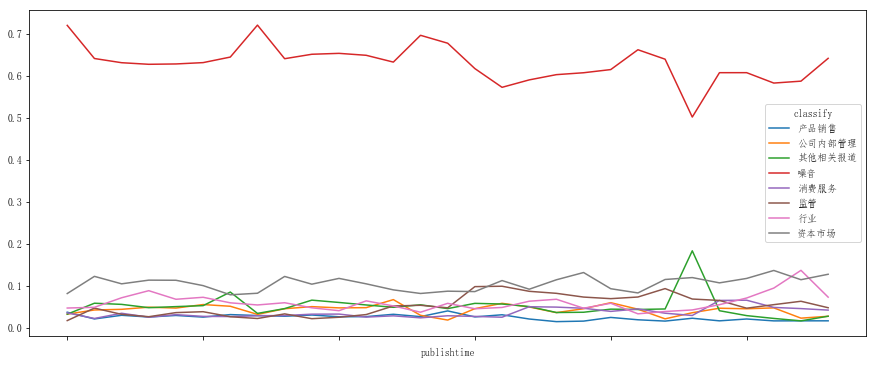

In [99]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

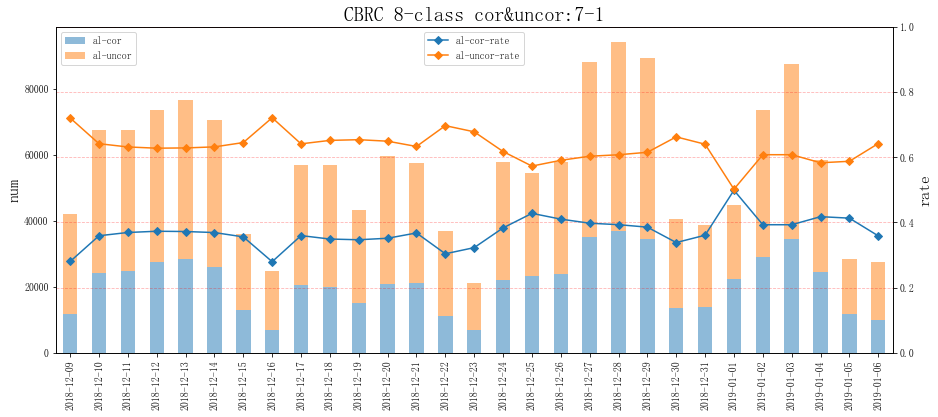

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-06  27615    9899     17716        0.358          0.642
27  2019-01-05  28510   11770     16740        0.413          0.587
26  2019-01-04  58439   24392     34047        0.417          0.583
25  2019-01-03  87561   34378     53183        0.393          0.607
24  2019-01-02  73604   28902     44702        0.393          0.607


In [100]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

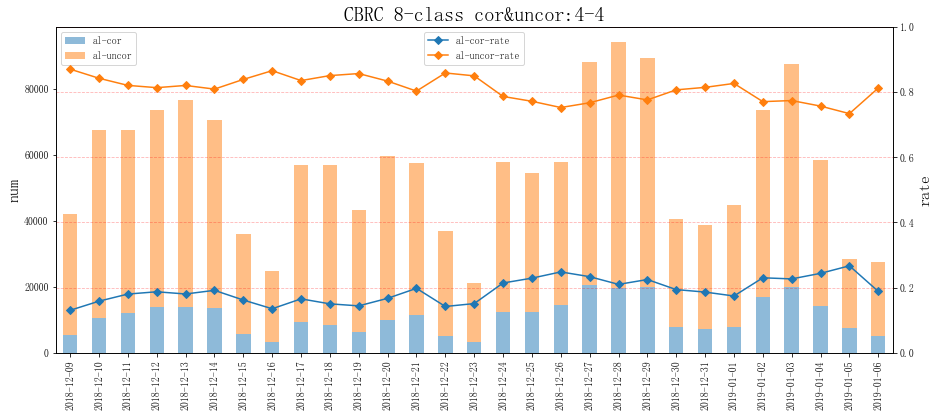

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-06     22416  27615    5199        0.188          0.812
27  2019-01-05     20906  28510    7604        0.267          0.733
26  2019-01-04     44203  58439   14236        0.244          0.756
25  2019-01-03     67721  87561   19840        0.227          0.773
24  2019-01-02     56679  73604   16925        0.230          0.770


In [101]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [102]:
class_count = cbirc_count[cbirc_count['type'] == '保监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2019-01-06    135    107     39  15045   582   411   353   954  17626   2581   
2019-01-05    152    337     55  17686   798  1018  1581  1382  23009   5323   
2019-01-04    554   1078    400  29455  1152  1713   996  2695  38043   8588   
2019-01-03    797   1597    450  46266  1505  1375  1099  3997  57086  10820   
2019-01-02    431    576    402  26196   841   778   918  2615  32757   6561   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2019-01-06   0.146 0.854  
2019-01-05   0.231 0.769  
2019-01-04   0.226 0.774  
2019-01-03   0.190 0.810  
2019-01-02   0.200 0.800

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2019-01-06    135    107     39  15045   582   411   353   954  17626 0.008   
2019-01-05    152    337     55  17686   798  1018  1581  1382  23009 0.007   
2019-01-04    554   1078    400  29455  1152  1713   996  2695  38043 0.015   
2019-01-03    797   1597    450  46266  1505  1375  1099  3997  57086 0.014   
2019-01-02    431    576    402  26196   841   778   918  2615  32757 0.013   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2019-01-06   0.006  0.002 0.854 0.033 0.023 0.020 0.054  
2019-01-05   0.015  0.002 0.769 0.035 0.044 0.069 0.060  
2019-01-04   0.028  0.011 0.774 0.030 0.045 0.026 0.071  
2019-01-03   0.028  0.008 0.810 0.026 0.024 0.019 0.070  
2019-01-02   0.018  0.012 0.800 0.026 0.024 0.028 0.080

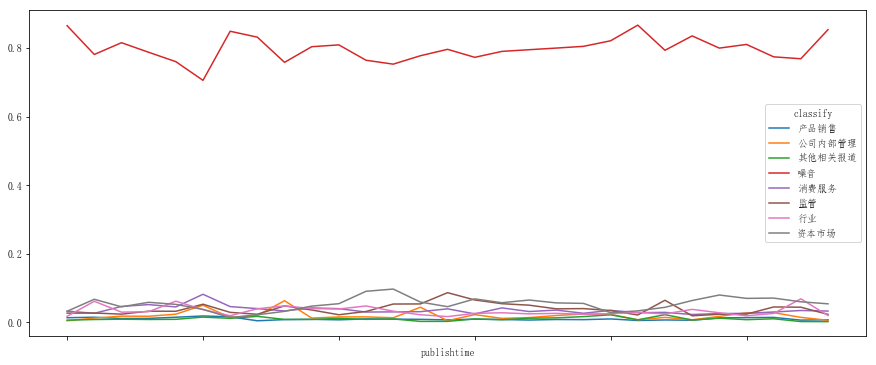

In [103]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

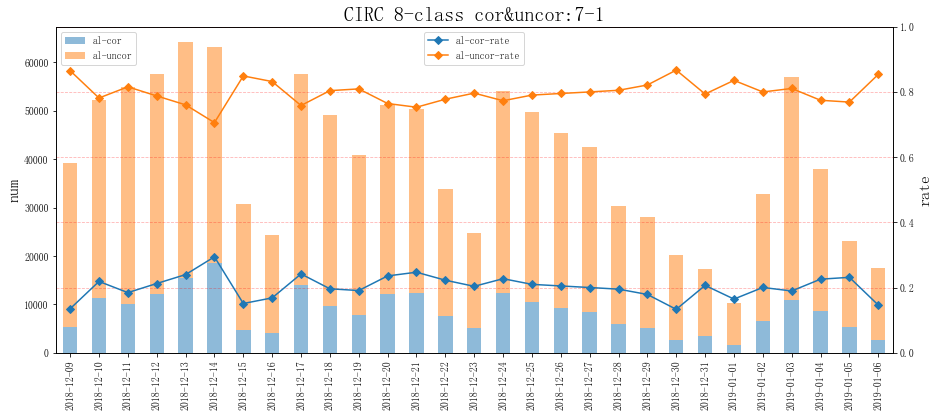

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-06  17626    2581     15045        0.146          0.854
27  2019-01-05  23009    5323     17686        0.231          0.769
26  2019-01-04  38043    8588     29455        0.226          0.774
25  2019-01-03  57086   10820     46266        0.190          0.810
24  2019-01-02  32757    6561     26196        0.200          0.800


In [104]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

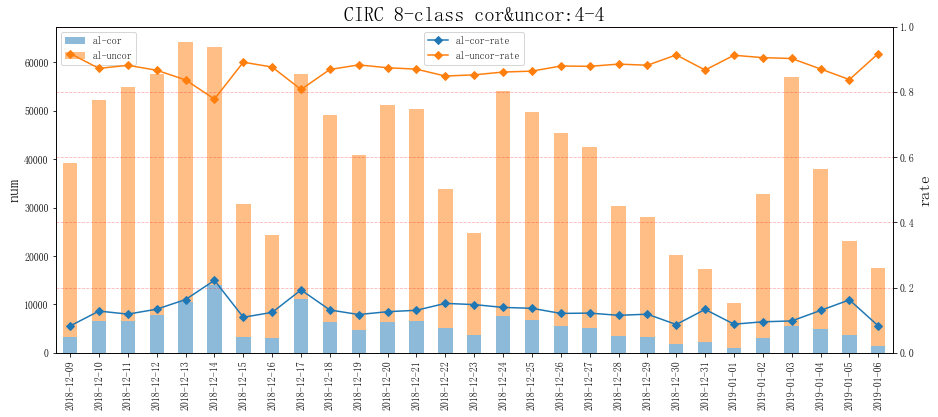

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-06     16173  17626    1453        0.082          0.918
27  2019-01-05     19275  23009    3734        0.162          0.838
26  2019-01-04     33104  38043    4939        0.130          0.870
25  2019-01-03     51510  57086    5576        0.098          0.902
24  2019-01-02     29644  32757    3113        0.095          0.905


In [105]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [106]:
class_count = cbirc_count[cbirc_count['type'] == '中国人寿'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                        \
classify      产品销售  公司内部管理 其他相关报道       噪音   消费服务     监管      行业    资本市场   
publishtime                                                                
2019-01-06   5.000  15.000  4.000 1310.000  3.000  6.000  54.000  13.000   
2019-01-05   1.000  16.000  1.000  906.000  7.000  6.000 260.000  20.000   
2019-01-04  13.000 202.000 11.000 1936.000 70.000 10.000 356.000 324.000   
2019-01-03  32.000 169.000 27.000 2990.000 26.000 19.000 888.000 430.000   
2019-01-02  18.000 114.000 13.000 1384.000 16.000 13.000 124.000 140.000   

                  总量      非噪音 非噪音-比例 噪音-比例  
classify                                    
publishtime                                 
2019-01-06  1410.000  100.000  0.071 0.929  
2019-01-05  1217.000  311.000  0.256 0.744  
2019-01-04  2922.000  986.000  0.337 0.663  
2019-01-03  4581.000 1591.000  0.347 0.653  
2019-01-02  1822.000  438.000  0.240 0.760

count                                                        \
classify      产品销售  公司内部管理 其他相关报道       噪音   消费服务     监管      行业    资本市场   
publishtime                                                                
2019-01-06   5.000  15.000  4.000 1310.000  3.000  6.000  54.000  13.000   
2019-01-05   1.000  16.000  1.000  906.000  7.000  6.000 260.000  20.000   
2019-01-04  13.000 202.000 11.000 1936.000 70.000 10.000 356.000 324.000   
2019-01-03  32.000 169.000 27.000 2990.000 26.000 19.000 888.000 430.000   
2019-01-02  18.000 114.000 13.000 1384.000 16.000 13.000 124.000 140.000   

                  总量  rate                                              
classify              产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                             
2019-01-06  1410.000 0.004  0.011  0.003 0.929 0.002 0.004 0.038 0.009  
2019-01-05  1217.000 0.001  0.013  0.001 0.744 0.006 0.005 0.214 0.016  
2019-01-04  2922.000 0.004  0.069  0.004 0.663 0.024 0.003 0.122 0.111  
2019-01-03  4581.000 0.007  0.037  0.006 0.653 0.006 0.004 0.194 0.094  
2019-01-02  1822.000 0.010  0.063  0.007 0.760 0.009 0.007 0.068 0.077

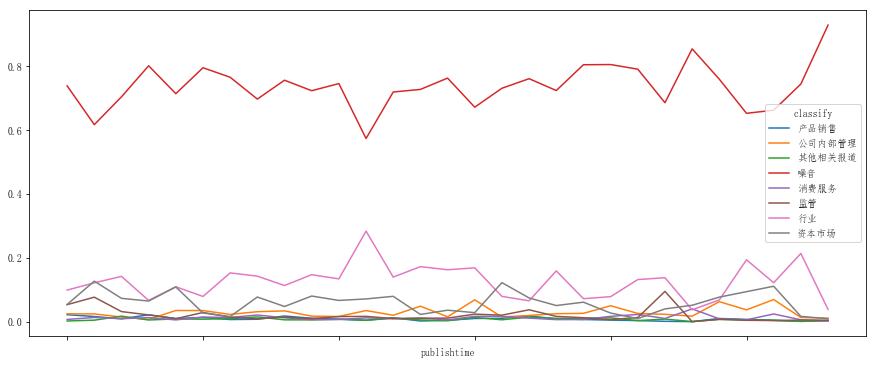

In [107]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

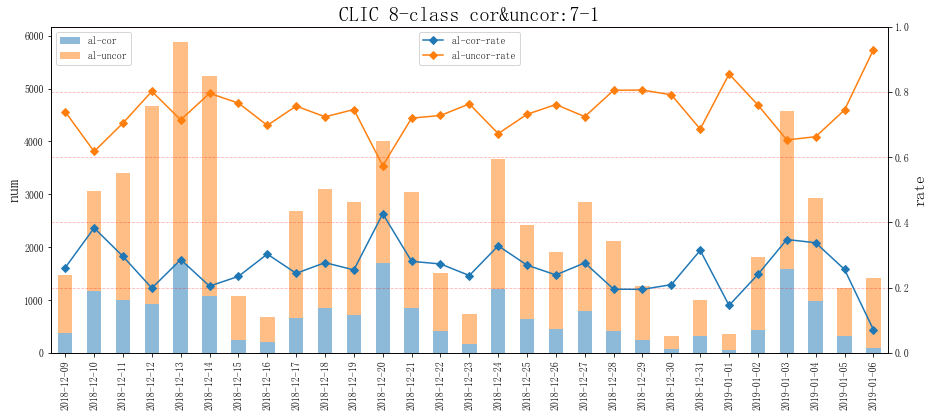

   publishtime      sum   al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-06 1410.000  100.000  1310.000        0.071          0.929
27  2019-01-05 1217.000  311.000   906.000        0.256          0.744
26  2019-01-04 2922.000  986.000  1936.000        0.337          0.663
25  2019-01-03 4581.000 1591.000  2990.000        0.347          0.653
24  2019-01-02 1822.000  438.000  1384.000        0.240          0.760


In [108]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

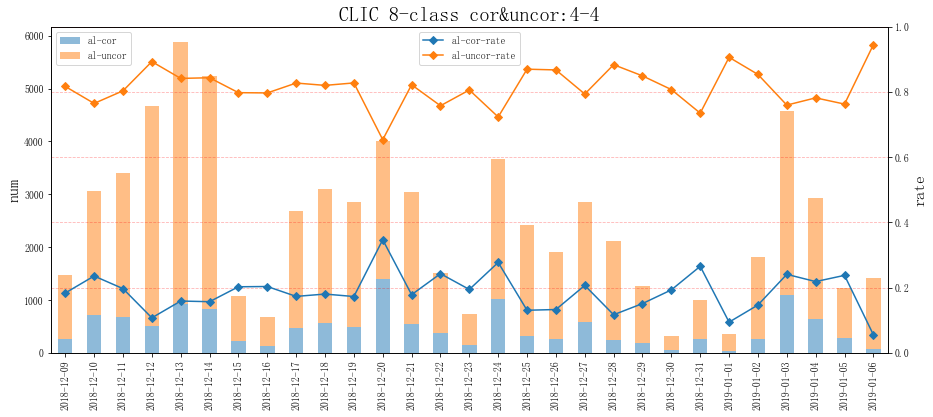

   publishtime  al_uncor      sum   al_cor  al_cor_rate  al_uncor_rate
28  2019-01-06  1332.000 1410.000   78.000        0.055          0.945
27  2019-01-05   928.000 1217.000  289.000        0.237          0.763
26  2019-01-04  2284.000 2922.000  638.000        0.218          0.782
25  2019-01-03  3479.000 4581.000 1102.000        0.241          0.759
24  2019-01-02  1555.000 1822.000  267.000        0.147          0.853


In [109]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [110]:
class_count = cbirc_count[cbirc_count['type'] == '建行北分'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                        \
classify     产品销售  公司内部管理 其他相关报道      噪音   消费服务      监管      行业    资本市场   
publishtime                                                               
2019-01-06  2.000   2.000  6.000 127.000  7.000  60.000 105.000  37.000   
2019-01-05  1.000   1.000  3.000 193.000  6.000 133.000  96.000   9.000   
2019-01-04    nan  15.000  8.000 214.000  9.000 292.000  88.000  19.000   
2019-01-03  3.000 124.000 10.000 431.000 29.000 230.000 114.000 106.000   
2019-01-02  1.000  48.000 56.000 694.000  9.000 426.000 299.000 131.000   

                  总量     非噪音 非噪音-比例 噪音-比例  
classify                                   
publishtime                                
2019-01-06   346.000 219.000  0.633 0.367  
2019-01-05   442.000 249.000  0.563 0.437  
2019-01-04   645.000 431.000  0.668 0.332  
2019-01-03  1047.000 616.000  0.588 0.412  
2019-01-02  1664.000 970.000  0.583 0.417

count                                                        \
classify     产品销售  公司内部管理 其他相关报道      噪音   消费服务      监管      行业    资本市场   
publishtime                                                               
2019-01-06  2.000   2.000  6.000 127.000  7.000  60.000 105.000  37.000   
2019-01-05  1.000   1.000  3.000 193.000  6.000 133.000  96.000   9.000   
2019-01-04    nan  15.000  8.000 214.000  9.000 292.000  88.000  19.000   
2019-01-03  3.000 124.000 10.000 431.000 29.000 230.000 114.000 106.000   
2019-01-02  1.000  48.000 56.000 694.000  9.000 426.000 299.000 131.000   

                  总量  rate                                              
classify              产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                             
2019-01-06   346.000 0.006  0.006  0.017 0.367 0.020 0.173 0.303 0.107  
2019-01-05   442.000 0.002  0.002  0.007 0.437 0.014 0.301 0.217 0.020  
2019-01-04   645.000   nan  0.023  0.012 0.332 0.014 0.453 0.136 0.029  
2019-01-03  1047.000 0.003  0.118  0.010 0.412 0.028 0.220 0.109 0.101  
2019-01-02  1664.000 0.001  0.029  0.034 0.417 0.005 0.256 0.180 0.079

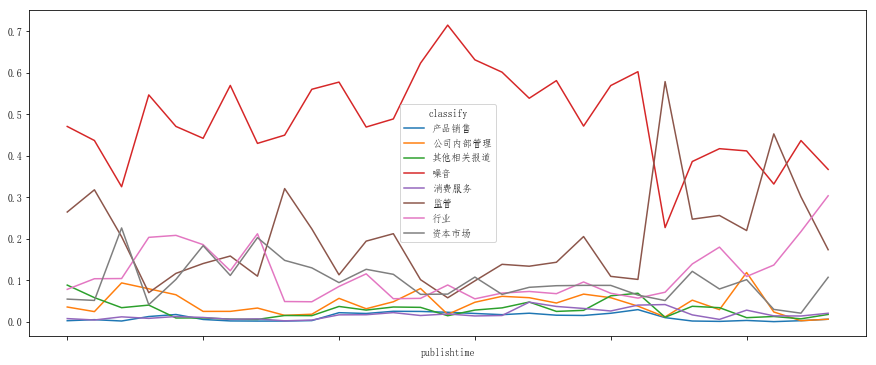

In [111]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

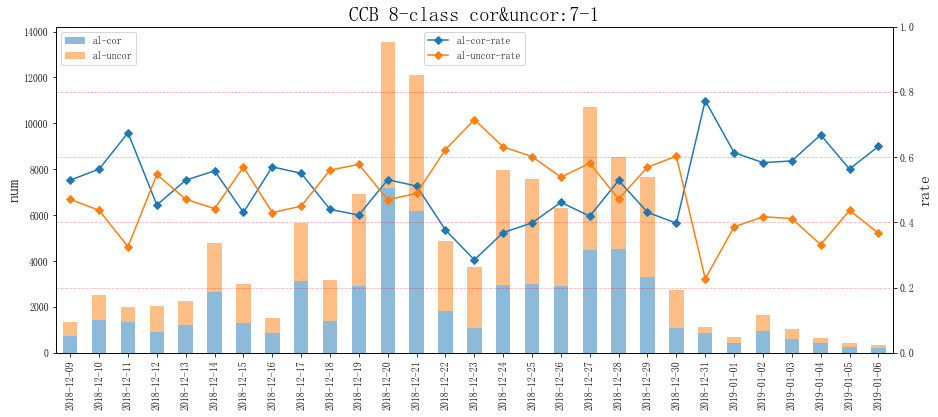

   publishtime      sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-06  346.000 219.000   127.000        0.633          0.367
27  2019-01-05  442.000 249.000   193.000        0.563          0.437
26  2019-01-04  645.000 431.000   214.000        0.668          0.332
25  2019-01-03 1047.000 616.000   431.000        0.588          0.412
24  2019-01-02 1664.000 970.000   694.000        0.583          0.417


In [112]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

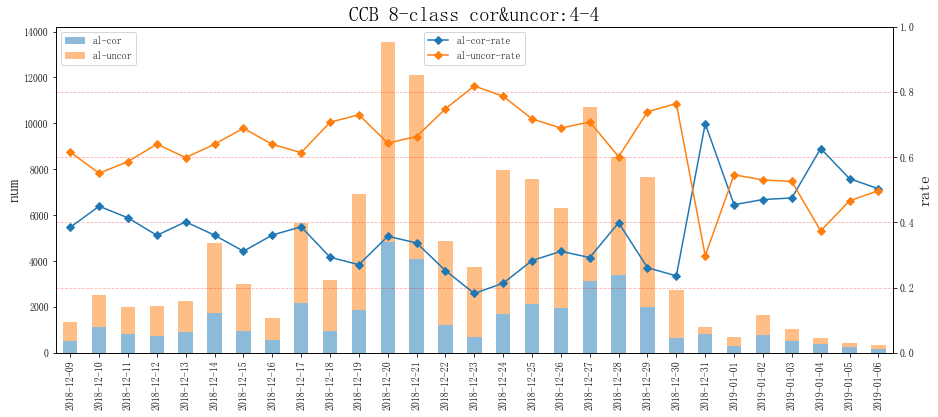

   publishtime  al_uncor      sum  al_cor  al_cor_rate  al_uncor_rate
28  2019-01-06   172.000  346.000 174.000        0.503          0.497
27  2019-01-05   206.000  442.000 236.000        0.534          0.466
26  2019-01-04   241.000  645.000 404.000        0.626          0.374
25  2019-01-03   550.000 1047.000 497.000        0.475          0.525
24  2019-01-02   882.000 1664.000 782.000        0.470          0.530


In [113]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

### 中国人保

In [114]:
class_count = cbirc_count[cbirc_count['type'] == '中国人保'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify          交通   产品销售  公司内部管理 其他相关报道        噪音    消费服务      环保     监管   
publishtime                                                                   
2019-01-06   547.000  2.000   3.000    nan  5555.000  16.000  90.000  7.000   
2019-01-05   664.000  1.000  11.000  1.000  4322.000  21.000  84.000  5.000   
2019-01-04   945.000  7.000 114.000 19.000  8753.000  78.000  92.000 23.000   
2019-01-03  2089.000 10.000 136.000 29.000 14556.000 106.000 440.000 10.000   
2019-01-02  1089.000 19.000  66.000 27.000  6252.000  55.000  97.000  6.000   

                                  总量      非噪音 非噪音-比例 噪音-比例  
classify         行业   资本市场                                  
publishtime                                                 
2019-01-06   49.000  5.000  6274.000  719.000  0.115 0.885  
2019-01-05   38.000 38.000  5185.000  863.000  0.166 0.834  
2019-01-04  198.000 67.000 10296.000 1543.000  0.150 0.850  
2019-01-03  330.000 33.000 17739.000 3183.000  0.179 0.821  
2019-01-02  310.000 70.000  7991.000 1739.000  0.218 0.782

count                                                         \
classify          交通   产品销售  公司内部管理 其他相关报道        噪音    消费服务      环保     监管   
publishtime                                                                   
2019-01-06   547.000  2.000   3.000    nan  5555.000  16.000  90.000  7.000   
2019-01-05   664.000  1.000  11.000  1.000  4322.000  21.000  84.000  5.000   
2019-01-04   945.000  7.000 114.000 19.000  8753.000  78.000  92.000 23.000   
2019-01-03  2089.000 10.000 136.000 29.000 14556.000 106.000 440.000 10.000   
2019-01-02  1089.000 19.000  66.000 27.000  6252.000  55.000  97.000  6.000   

                            ...   rate                                        \
classify         行业   资本市场  ...     交通  产品销售 公司内部管理 其他相关报道    噪音  消费服务    环保   
publishtime                 ...                                                
2019-01-06   49.000  5.000  ...  0.087 0.000  0.000    nan 0.885 0.003 0.014   
2019-01-05   38.000 38.000  ...  0.128 0.000  0.002  0.000 0.834 0.004 0.016   
2019-01-04  198.000 67.000  ...  0.092 0.001  0.011  0.002 0.850 0.008 0.009   
2019-01-03  330.000 33.000  ...  0.118 0.001  0.008  0.002 0.821 0.006 0.025   
2019-01-02  310.000 70.000  ...  0.136 0.002  0.008  0.003 0.782 0.007 0.012   

                               
classify       监管    行业  资本市场  
publishtime                    
2019-01-06  0.001 0.008 0.001  
2019-01-05  0.001 0.007 0.007  
2019-01-04  0.002 0.019 0.007  
2019-01-03  0.001 0.019 0.002  
2019-01-02  0.001 0.039 0.009  

[5 rows x 21 columns]

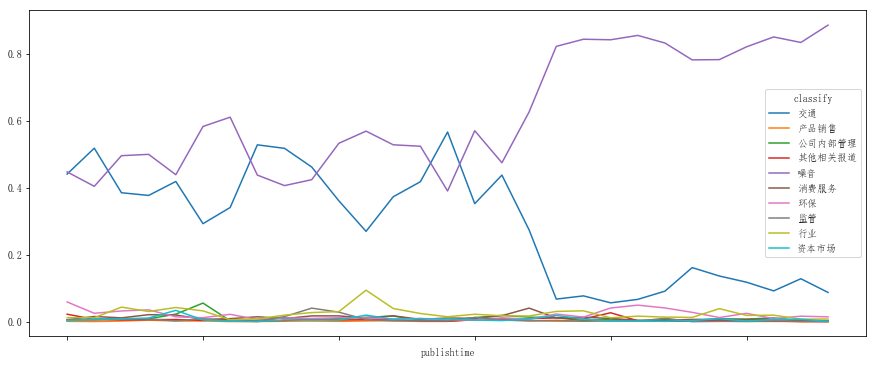

In [115]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

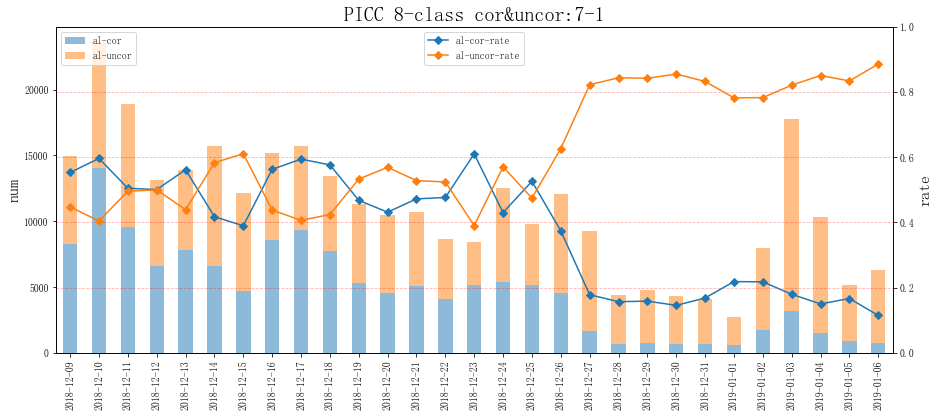

   publishtime       sum   al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2019-01-06  6274.000  719.000  5555.000        0.115          0.885
27  2019-01-05  5185.000  863.000  4322.000        0.166          0.834
26  2019-01-04 10296.000 1543.000  8753.000        0.150          0.850
25  2019-01-03 17739.000 3183.000 14556.000        0.179          0.821
24  2019-01-02  7991.000 1739.000  6252.000        0.218          0.782


In [116]:
plot_cor(count_data_7, cbirc_day_thing, "PICC 8-class cor&uncor:7-1")

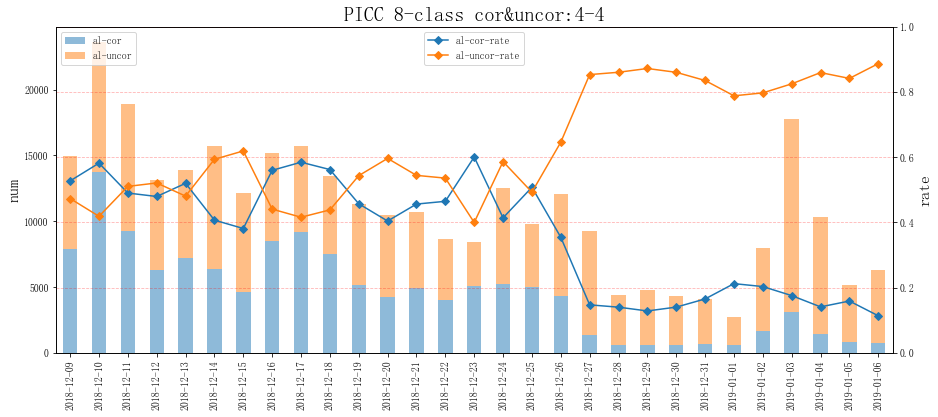

   publishtime  al_uncor       sum   al_cor  al_cor_rate  al_uncor_rate
28  2019-01-06  5562.000  6274.000  712.000        0.113          0.887
27  2019-01-05  4362.000  5185.000  823.000        0.159          0.841
26  2019-01-04  8846.000 10296.000 1450.000        0.141          0.859
25  2019-01-03 14628.000 17739.000 3111.000        0.175          0.825
24  2019-01-02  6368.000  7991.000 1623.000        0.203          0.797


In [117]:
plot_cor(count_data_4, cbirc_day_thing, "PICC 8-class cor&uncor:4-4")

## 倾向性
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

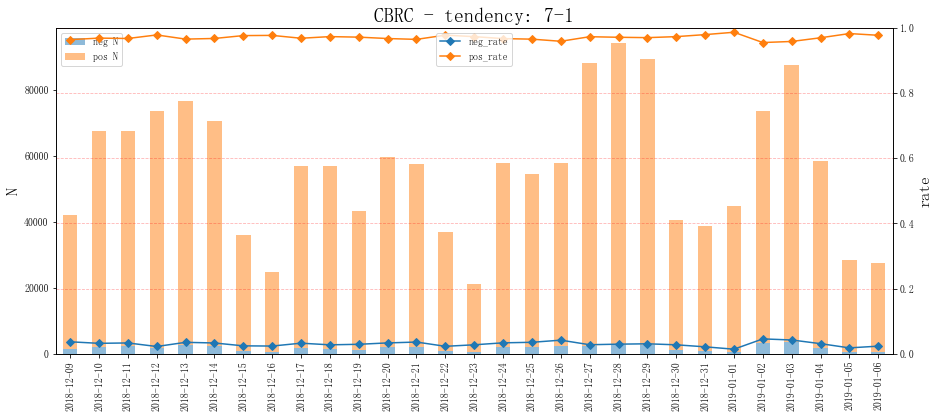

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2019-01-06   647  26968  27615     0.023     0.977
27  2019-01-05   518  27992  28510     0.018     0.982
26  2019-01-04  1816  56623  58439     0.031     0.969
25  2019-01-03  3711  83850  87561     0.042     0.958
24  2019-01-02  3363  70241  73604     0.046     0.954


In [118]:
plot_tend(tend_count[tend_count['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 7-1")

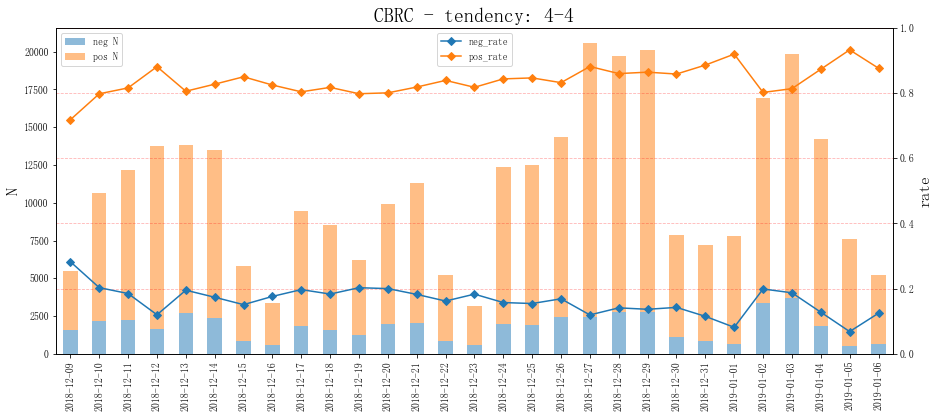

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2019-01-06   647   4552   5199     0.124     0.876
27  2019-01-05   518   7086   7604     0.068     0.932
26  2019-01-04  1816  12420  14236     0.128     0.872
25  2019-01-03  3711  16129  19840     0.187     0.813
24  2019-01-02  3363  13562  16925     0.199     0.801


In [119]:
plot_tend(tend_count_4[tend_count_4['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 4-4")

### 保监会

In [120]:
plot_tend(tend_count[tend_count['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 7-1")

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [ ]:
plot_tend(tend_count_4[tend_count_4['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 4-4")

### 中国人寿

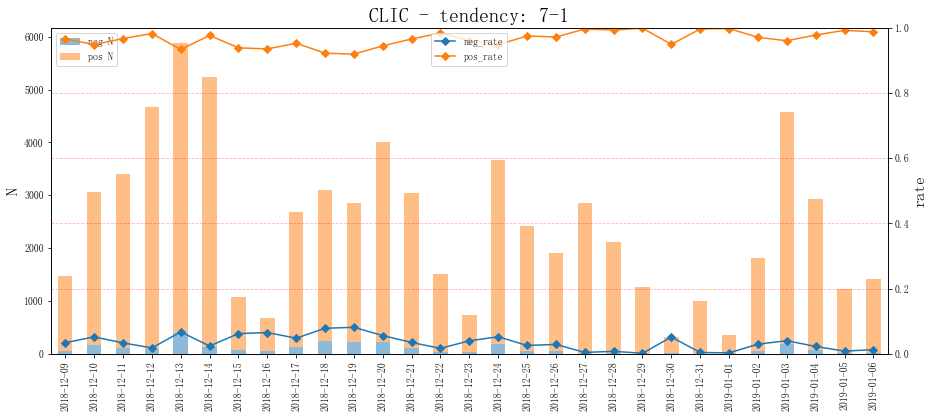

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-06   18  1392  1410     0.013     0.987
27  2019-01-05   10  1207  1217     0.008     0.992
26  2019-01-04   66  2856  2922     0.023     0.977
25  2019-01-03  184  4397  4581     0.040     0.960
24  2019-01-02   54  1768  1822     0.030     0.970


In [121]:
plot_tend(tend_count[tend_count['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 7-1")

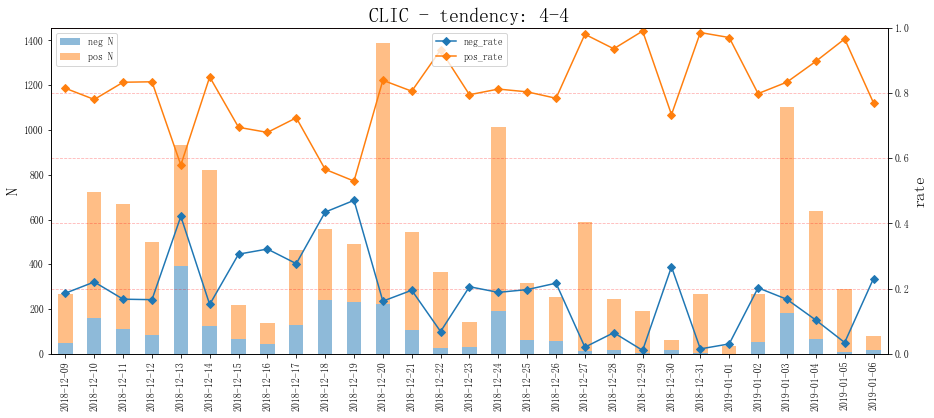

   publishtime  neg  pos   sum  neg_rate  pos_rate
28  2019-01-06   18   60    78     0.231     0.769
27  2019-01-05   10  279   289     0.035     0.965
26  2019-01-04   66  572   638     0.103     0.897
25  2019-01-03  184  918  1102     0.167     0.833
24  2019-01-02   54  213   267     0.202     0.798


In [122]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 4-4")

### 建行北分

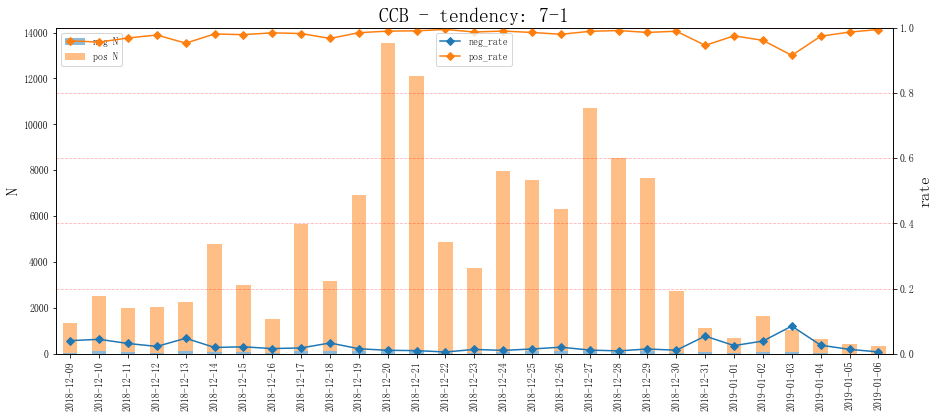

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-06    2   344   346     0.006     0.994
27  2019-01-05    6   436   442     0.014     0.986
26  2019-01-04   17   628   645     0.026     0.974
25  2019-01-03   89   958  1047     0.085     0.915
24  2019-01-02   65  1599  1664     0.039     0.961


In [123]:
plot_tend(tend_count[(tend_count['type'] == '建行北分')&(tend_count['tendency'] != 1)].drop('type', axis = 1), 
          cbirc_day_thing, "CCB - tendency: 7-1")

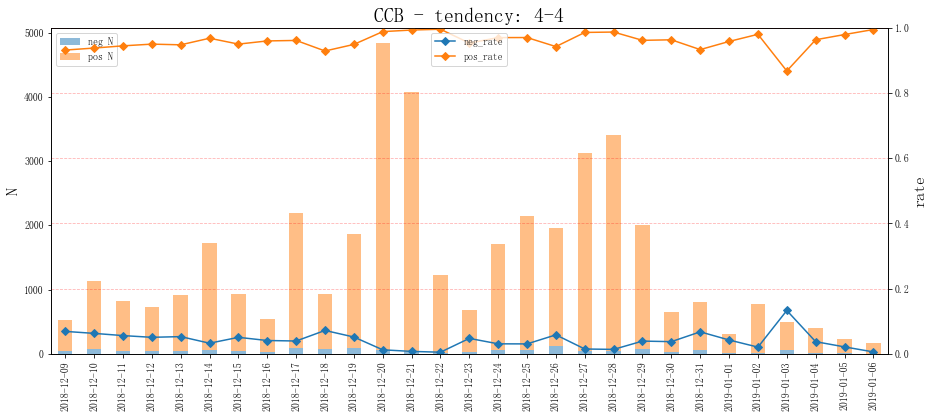

   publishtime  neg  pos  sum  neg_rate  pos_rate
28  2019-01-06    1  173  174     0.006     0.994
27  2019-01-05    5  231  236     0.021     0.979
26  2019-01-04   15  389  404     0.037     0.963
25  2019-01-03   66  431  497     0.133     0.867
24  2019-01-02   16  766  782     0.020     0.980


In [124]:
plot_tend(tend_count_4[(tend_count_4['type'] == '建行北分')&(tend_count_4['tendency'] != 1)].drop('type', axis = 1), 
          cbirc_day_thing, "CCB - tendency: 4-4")

### 中国人保

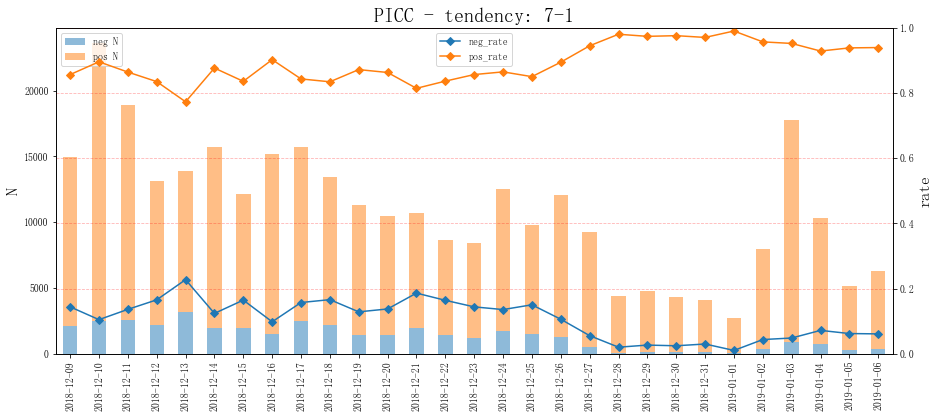

   publishtime  neg    pos    sum  neg_rate  pos_rate
28  2019-01-06  383   5891   6274     0.061     0.939
27  2019-01-05  322   4863   5185     0.062     0.938
26  2019-01-04  739   9557  10296     0.072     0.928
25  2019-01-03  859  16880  17739     0.048     0.952
24  2019-01-02  349   7642   7991     0.044     0.956


In [125]:
plot_tend(tend_count[tend_count['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 7-1")

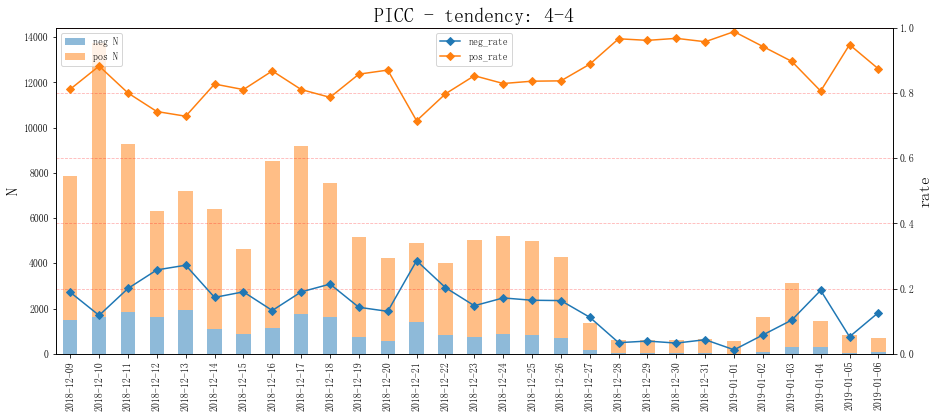

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2019-01-06   90   622   712     0.126     0.874
27  2019-01-05   43   780   823     0.052     0.948
26  2019-01-04  282  1168  1450     0.194     0.806
25  2019-01-03  322  2789  3111     0.104     0.896
24  2019-01-02   94  1529  1623     0.058     0.942


In [126]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 4-4")

## 补录和预警
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [127]:
# plot_add(cbirc_add[cbirc_add['type'] == '银监会'], cbirc_day_thing, "（银监会）人工补录")

### 保监会

In [128]:
# plot_add(cbirc_add[cbirc_add['type'] == '保监会'], cbirc_day_thing, "（保监会）人工补录")

### 中国人寿

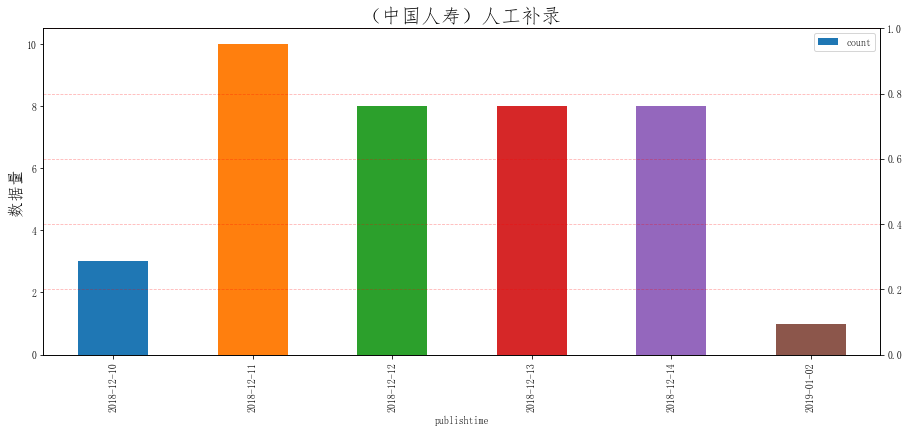

  publishtime  count
5  2019-01-02      1
4  2018-12-14      8
3  2018-12-13      8
2  2018-12-12      8
1  2018-12-11     10


In [129]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人寿'], cbirc_day_thing, "（中国人寿）人工补录")

### 建行北分

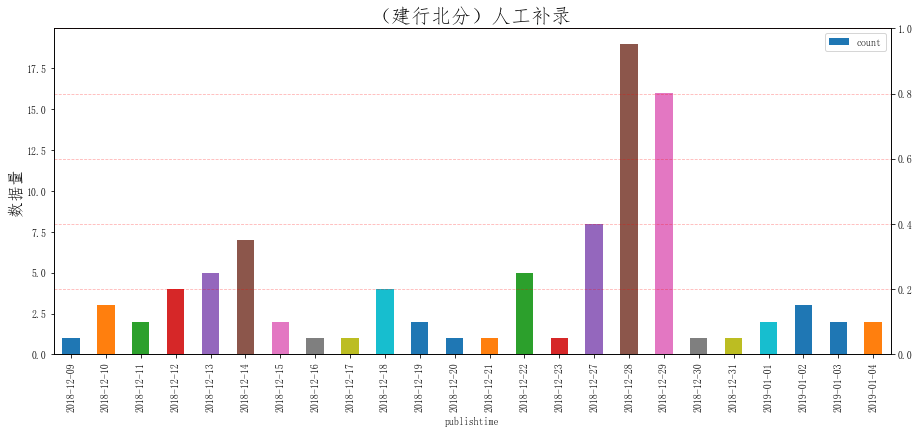

   publishtime  count
23  2019-01-04      2
22  2019-01-03      2
21  2019-01-02      3
20  2019-01-01      2
19  2018-12-31      1


In [130]:
plot_add(cbirc_add[cbirc_add['type'] == '建行北分'], cbirc_day_thing, "（建行北分）人工补录")

### 中国人保

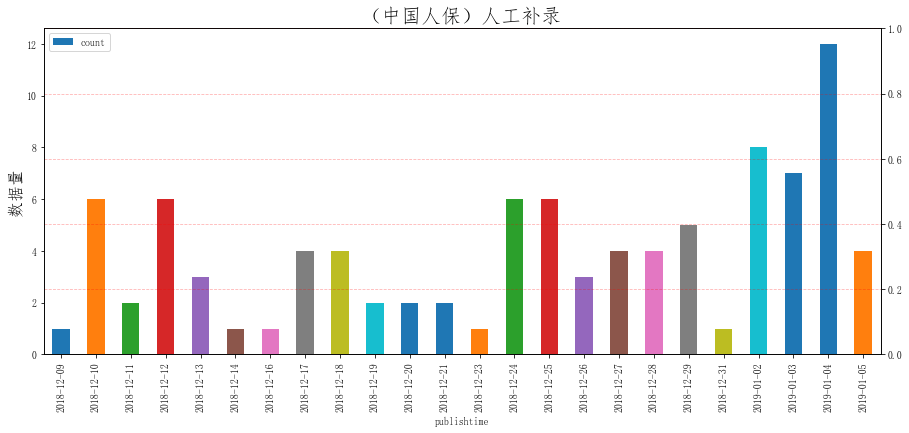

   publishtime  count
23  2019-01-05      4
22  2019-01-04     12
21  2019-01-03      7
20  2019-01-02      8
19  2018-12-31      1


In [131]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人保'], cbirc_day_thing, "（中国人保）人工补录")

In [ ]:
from tqdm import tqdm,trange
from time import sleep

for i in tqdm(range(10), desc='1st loop'):
    for j in trange(100, desc='2nd loop', leave=False):
        sleep(0.01)